In [1]:
# import tensorflow as tf
# from tensorflow import keras
# import numpy as np

# tf.config.list_physical_devices('GPU')

In [2]:
import tensorflow as tf
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
temp = []
for v in speech_data["label_vals"]:
    # print(v[0])
    temp.append(label_value[v[0]])
label_data = np.array(temp)

# print(label_data)

In [6]:
# !pip install librosa

In [7]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [8]:
# 위에서 뽑았던 sample data -> 2차원 data
spec_data = []
for wav in speech_data["wav_vals"]:
    spec = wav2spec(wav)
    
    spec_data.append(spec)

# print("Waveform shape : ",data.shape)
# print("Spectrogram shape : ",spec.shape)

In [9]:
spec_data = np.array(spec_data)

In [10]:
from sklearn.model_selection import train_test_split

sr = 130 # 1초동안 재생되는 샘플의 갯수?
sc = 126
train_wav, test_wav, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
# print(train_wav)
# print(train_wav.shape)

train_wav = train_wav.reshape(-1, sr, sc, 1) # add channel for CNN
test_wav = test_wav.reshape(-1, sr, sc, 1)

# print(train_wav.shape)
# print("✅")

In [11]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
# print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)


In [12]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/skip'

checkpoint_dir

'/home/ssac2/aiffel/speech_recognition/models/skip'

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [14]:
print(train_wav.shape, train_label.shape)

(45558, 130, 126, 1) (45558,)


In [15]:
import tensorflow as tf

print(train_wav.shape, train_label.shape)
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
print(train_dataset)
train_dataset = train_dataset.map(one_hot_label)
print(train_dataset)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

(45558, 130, 126, 1) (45558,)
<TensorSliceDataset shapes: ((130, 126, 1), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((130, 126, 1), (12,)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
del spec_data

In [20]:
# 메모리 사용량 주의!
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.7762
Epoch 00001: val_loss improved from inf to 0.29540, saving model to /home/ssac2/aiffel/speech_recognition/models/skip
1423/1423 [==============================] - 217s 152ms/step - loss: 0.6921 - accuracy: 0.7762 - val_loss: 0.2954 - val_accuracy: 0.9062
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9361
Epoch 00002: val_loss improved from 0.29540 to 0.17269, saving model to /home/ssac2/aiffel/speech_recognition/models/skip
1423/1423 [==============================] - 216s 152ms/step - loss: 0.2014 - accuracy: 0.9361 - val_loss: 0.1727 - val_accuracy: 0.9462
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9569
Epoch 00003: val_loss improved from 0.17269 to 0.16425, saving model to /home/ssac2/aiffel/speech_recognition/models/skip
1423/1423 [==============================] - 217s 153ms/step - loss: 0.13

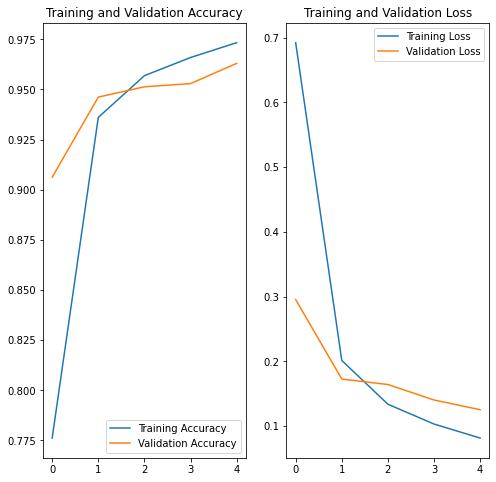

✅


In [21]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [22]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [23]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 26s 162ms/step - loss: 0.1257 - accuracy: 0.9629
✅


In [24]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.126
accuracy value: 96.2861%
✅


In [ ]:
import IPython.display as ipd
import random

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc,), rate = sr*sc)

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")